In [727]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from scipy import signal

In [728]:
#Read image file
img_bgr = cv2.imread("Image.jpg")
im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(float)

In [729]:
# Load VGG16 model from tensorflow.keras
model = VGG16()
# model detail
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [730]:
# retrieve kernel weights from the 1st Convolutional layer
kernels, biases = model.layers[1].get_weights()
# View CNN layer 1 architecture
model.layers[1].get_config()
print(kernels.shape)

(3, 3, 3, 64)


In [731]:
# Preprocess Image using keras and numpy
im_rgb = cv2.resize(im_rgb, (224,224), interpolation = cv2.INTER_AREA)
# convert the image to an array
im_rgb = img_to_array(im_rgb)
# expand dimensions so that it represents a single 'sample’
im_rgb = expand_dims(im_rgb, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img_ready = preprocess_input(im_rgb)
print(img_ready.shape)

(1, 224, 224, 3)


In [732]:
# Extract Model CNN Layer 1
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [733]:
# Extract Results from CNN Layer 1 called feature map (shape = (sample = 1, 224, 224, n_filters) )
feature_maps = model.predict(img_ready)
print(feature_maps.shape)

(1, 224, 224, 64)


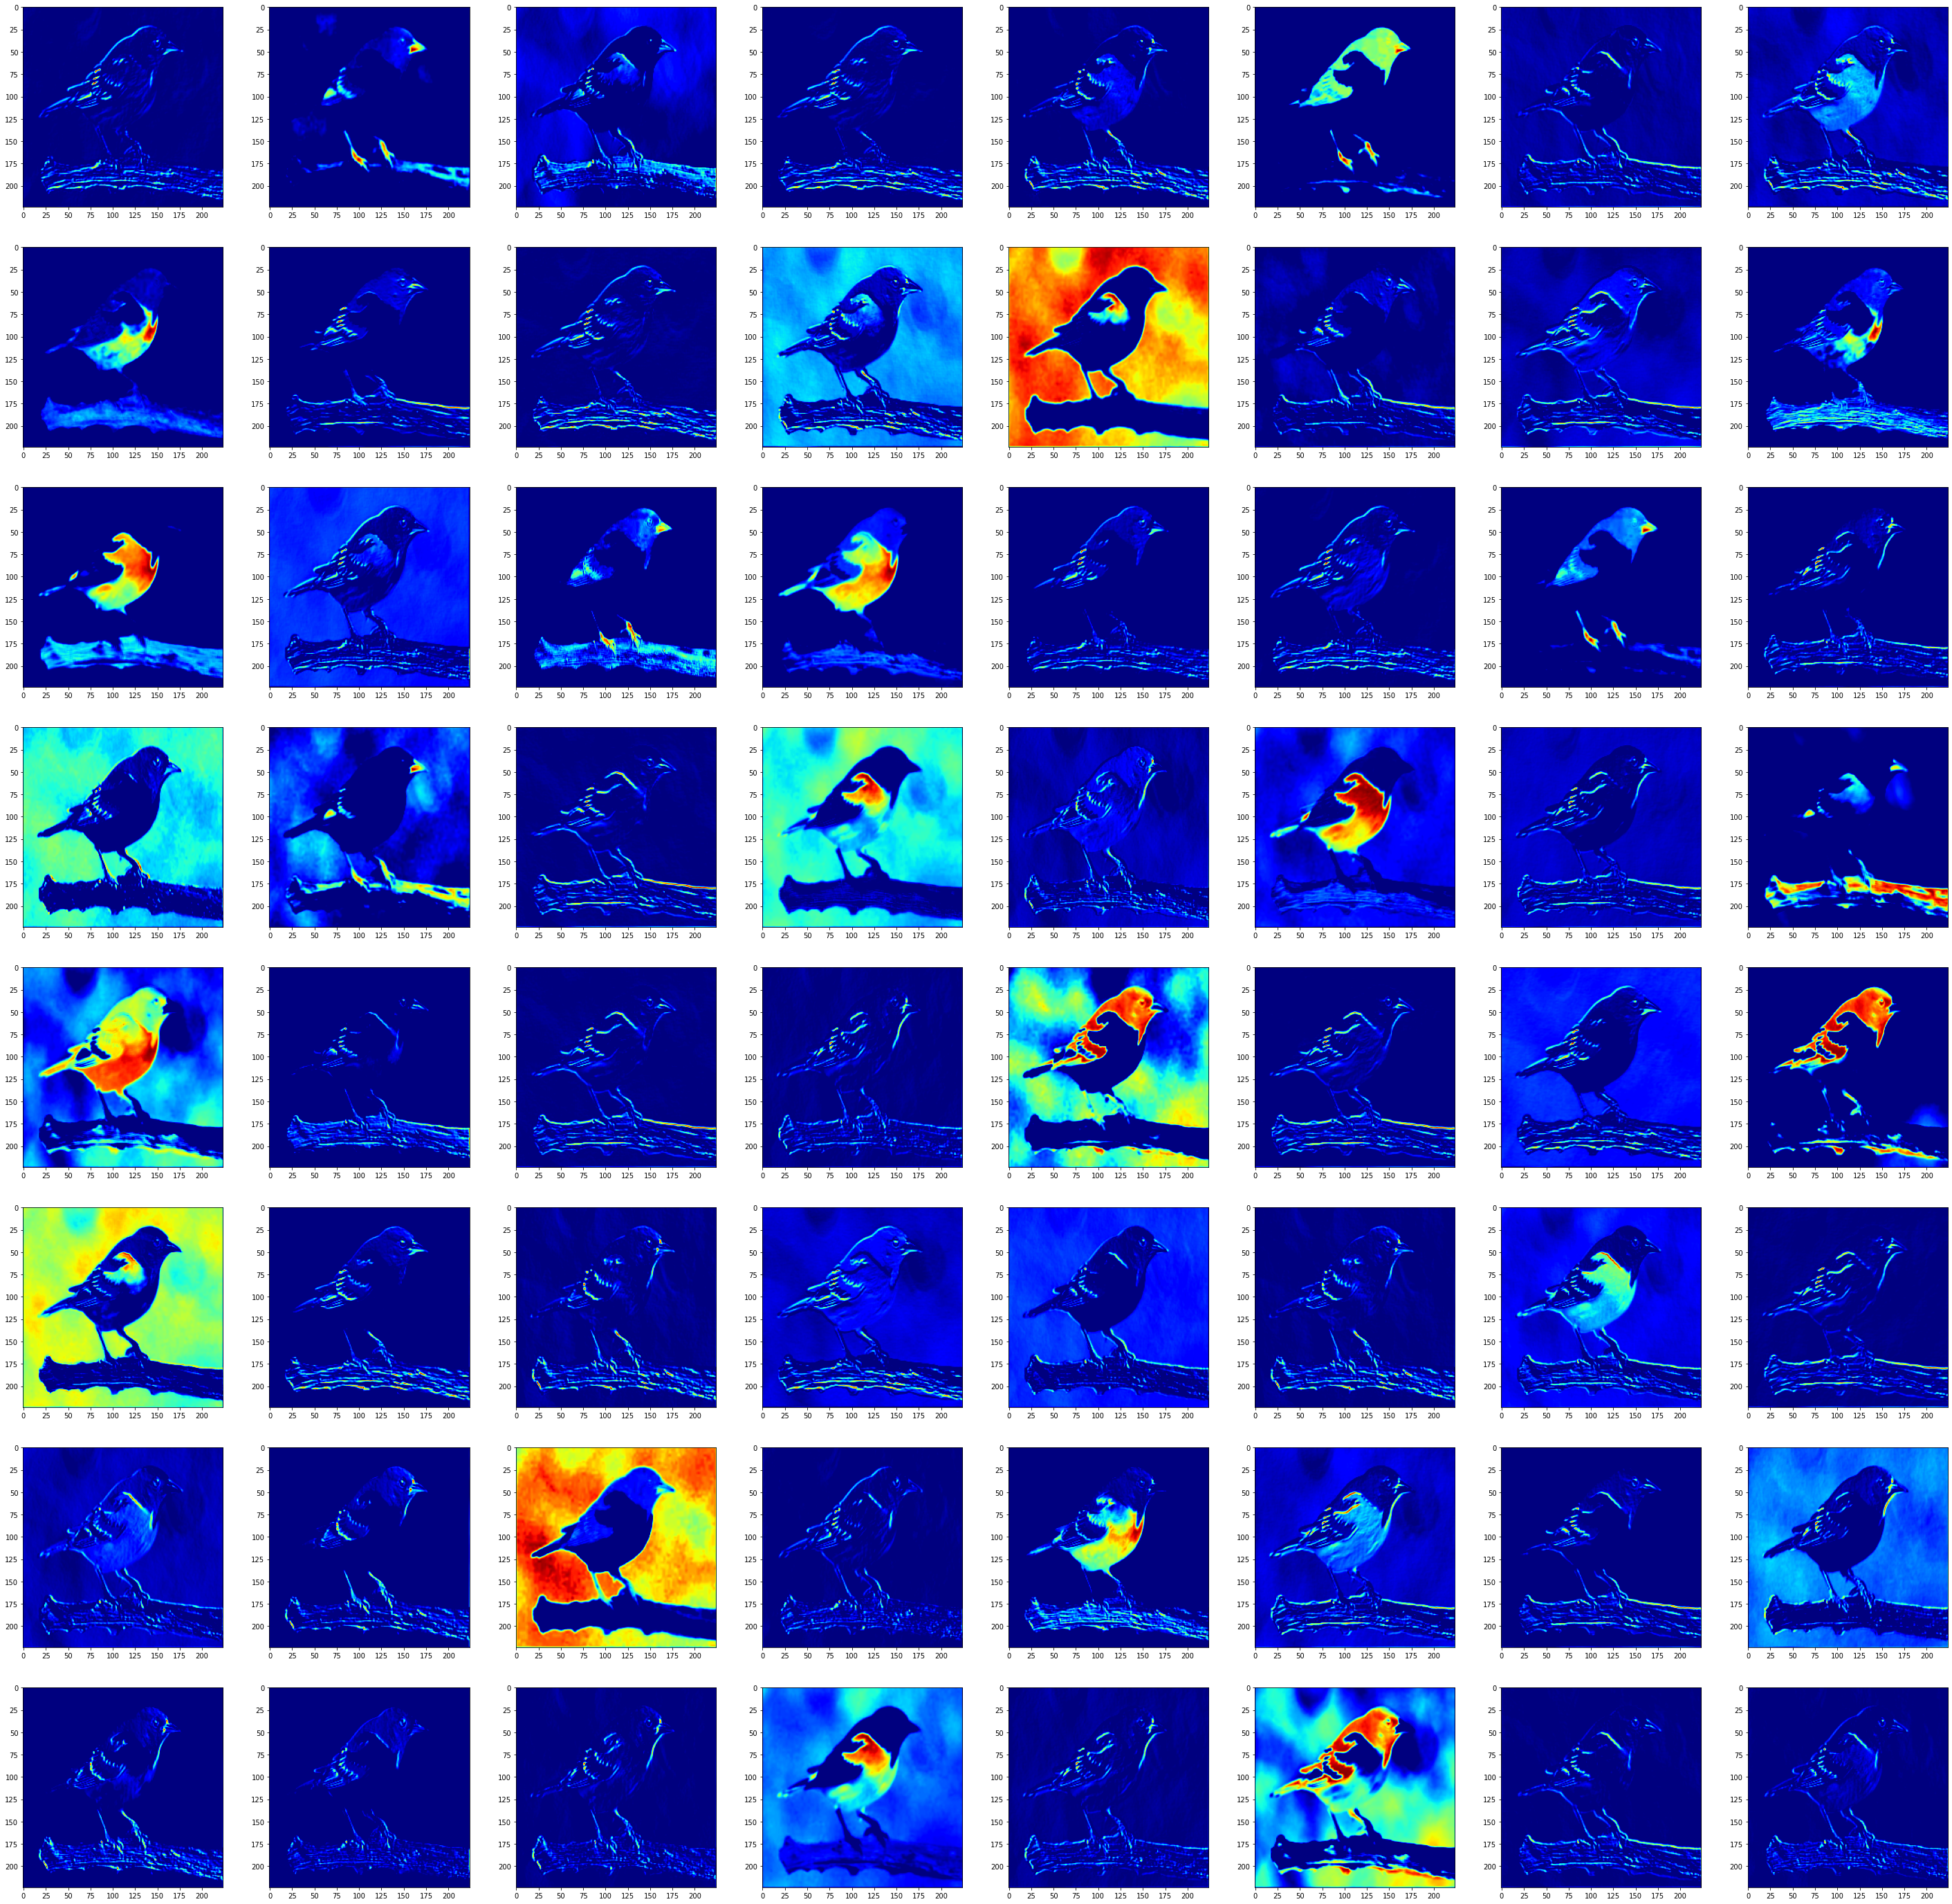

In [734]:
square = 8
ix = 1
plt.figure(figsize=(50,50))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        # plot filter channel
        plt.imshow(feature_maps[0, :, :, ix-1],cmap = "jet")
        ix += 1
        # show the figure


In [761]:
# Image reshape from 3D image (H, W, Ch) -> 4D image (1, H, W, Ch)
#• Read image
img_bgr = cv2.imread("Image.jpg")
im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(float)
# Reshape
im_rgb = im_rgb.reshape(1,im_rgb.shape[0],im_rgb.shape[1],im_rgb.shape[2])

print(im_rgb.shape)

(1, 549, 976, 3)


In [762]:
#Image resize(H,W) -> (224,224)
img_resize = im_rgb.copy()
lst = []
for i in im_rgb:
    img_resize = cv2.resize(i, (224, 224), interpolation=cv2.INTER_AREA)
    lst.append(img_resize)
img_resize = np.stack(lst,axis=0)
print(img_resize.shape)

(1, 224, 224, 3)


In [763]:
# Image subtract dataset mean of R, G, B
#img_mean = [np.mean(img_resize[0,:,:,0]), np.mean(img_resize[0,:,:,1]), np.mean(img_resize[0,:,:,2])] # -> [meanR, meanG, meanB]
img_mean = [123.68, 116.779, 103.939] # -> [meanR, meanG, meanB]
img_resize[0,:,:,0] = cv2.subtract(img_resize[0,:,:,0],img_mean[0])
img_resize[0,:,:,1] = cv2.subtract(img_resize[0,:,:,1],img_mean[1])
img_resize[0,:,:,2] = cv2.subtract(img_resize[0,:,:,2],img_mean[2])

In [764]:
#Color conversion
img_bgr = np.zeros((1, 224,224,3))
img_bgr[0] = img_resize[0][:, :, [2, 1, 0]]
#img_bgr[0] = cv2.cvtColor(img_resize[0], cv2.COLOR_RGB2BGR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


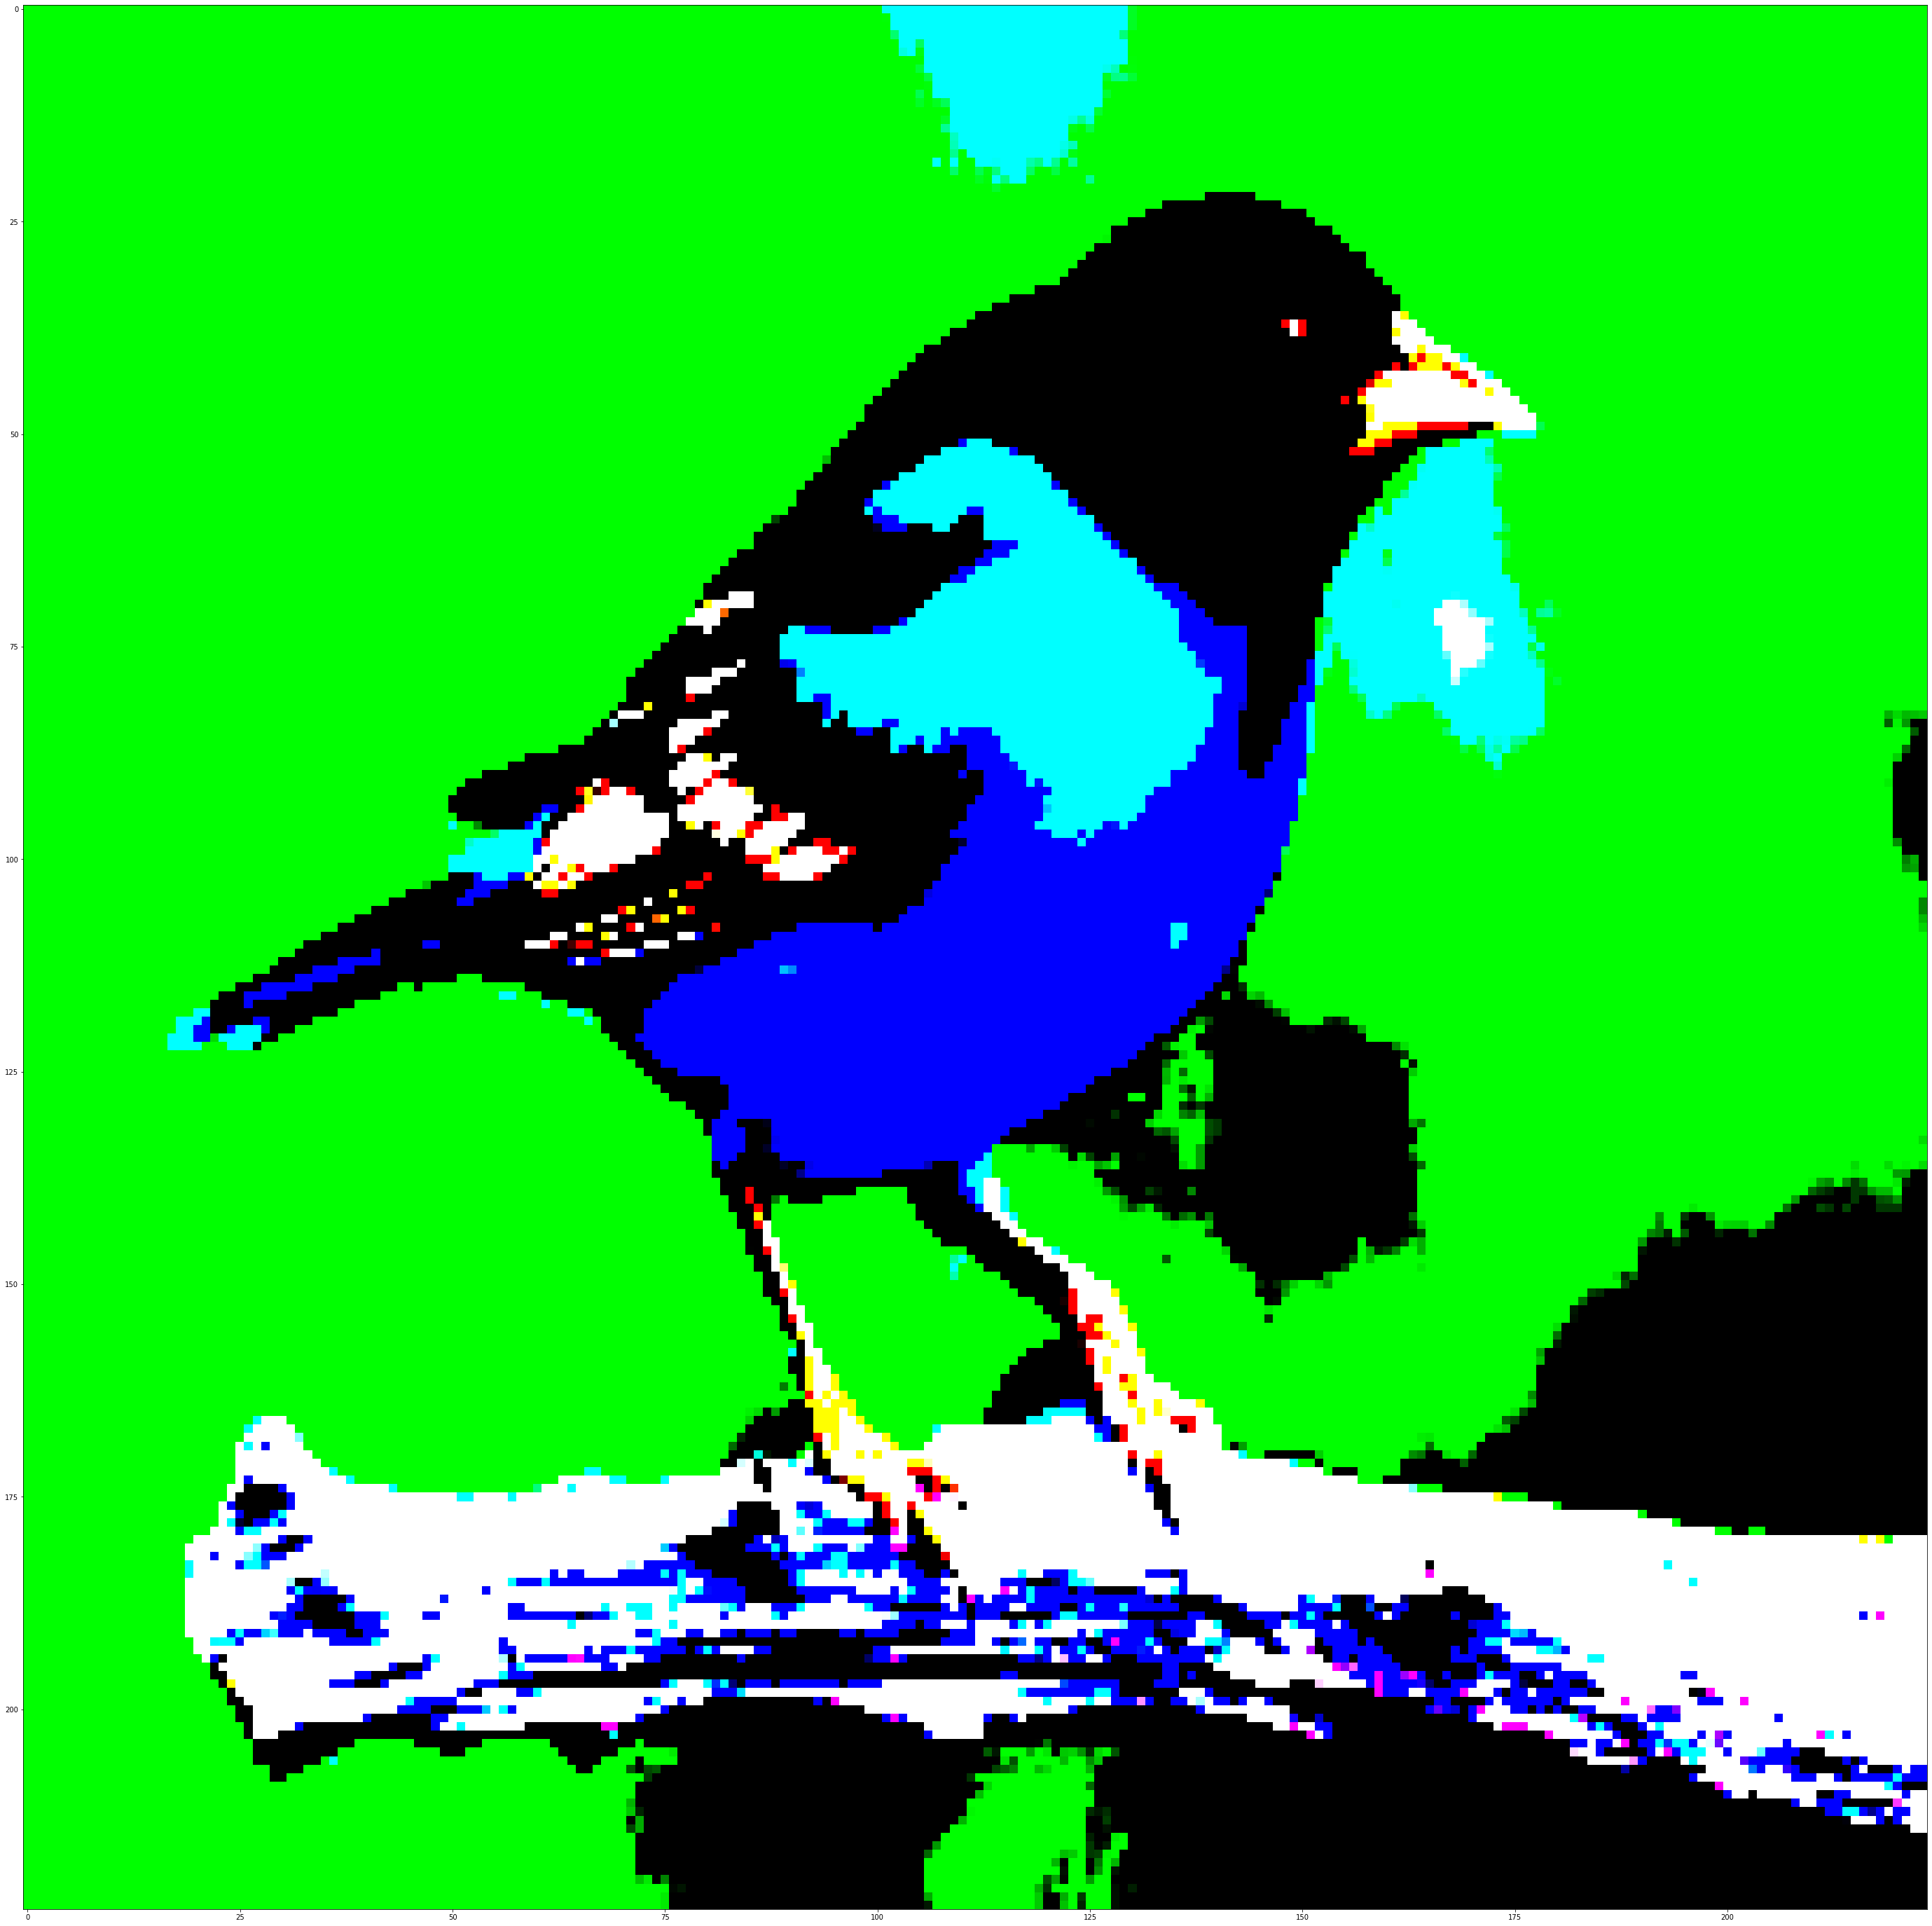

In [765]:
plt.figure(figsize=(50,50))
plt.subplot(1, 1, 1)
a = plt.imshow(img_bgr[0])

In [766]:
# operate 2D convolution to image from 4.2 (imgBGR)
img_result = np.zeros((224,224,3))

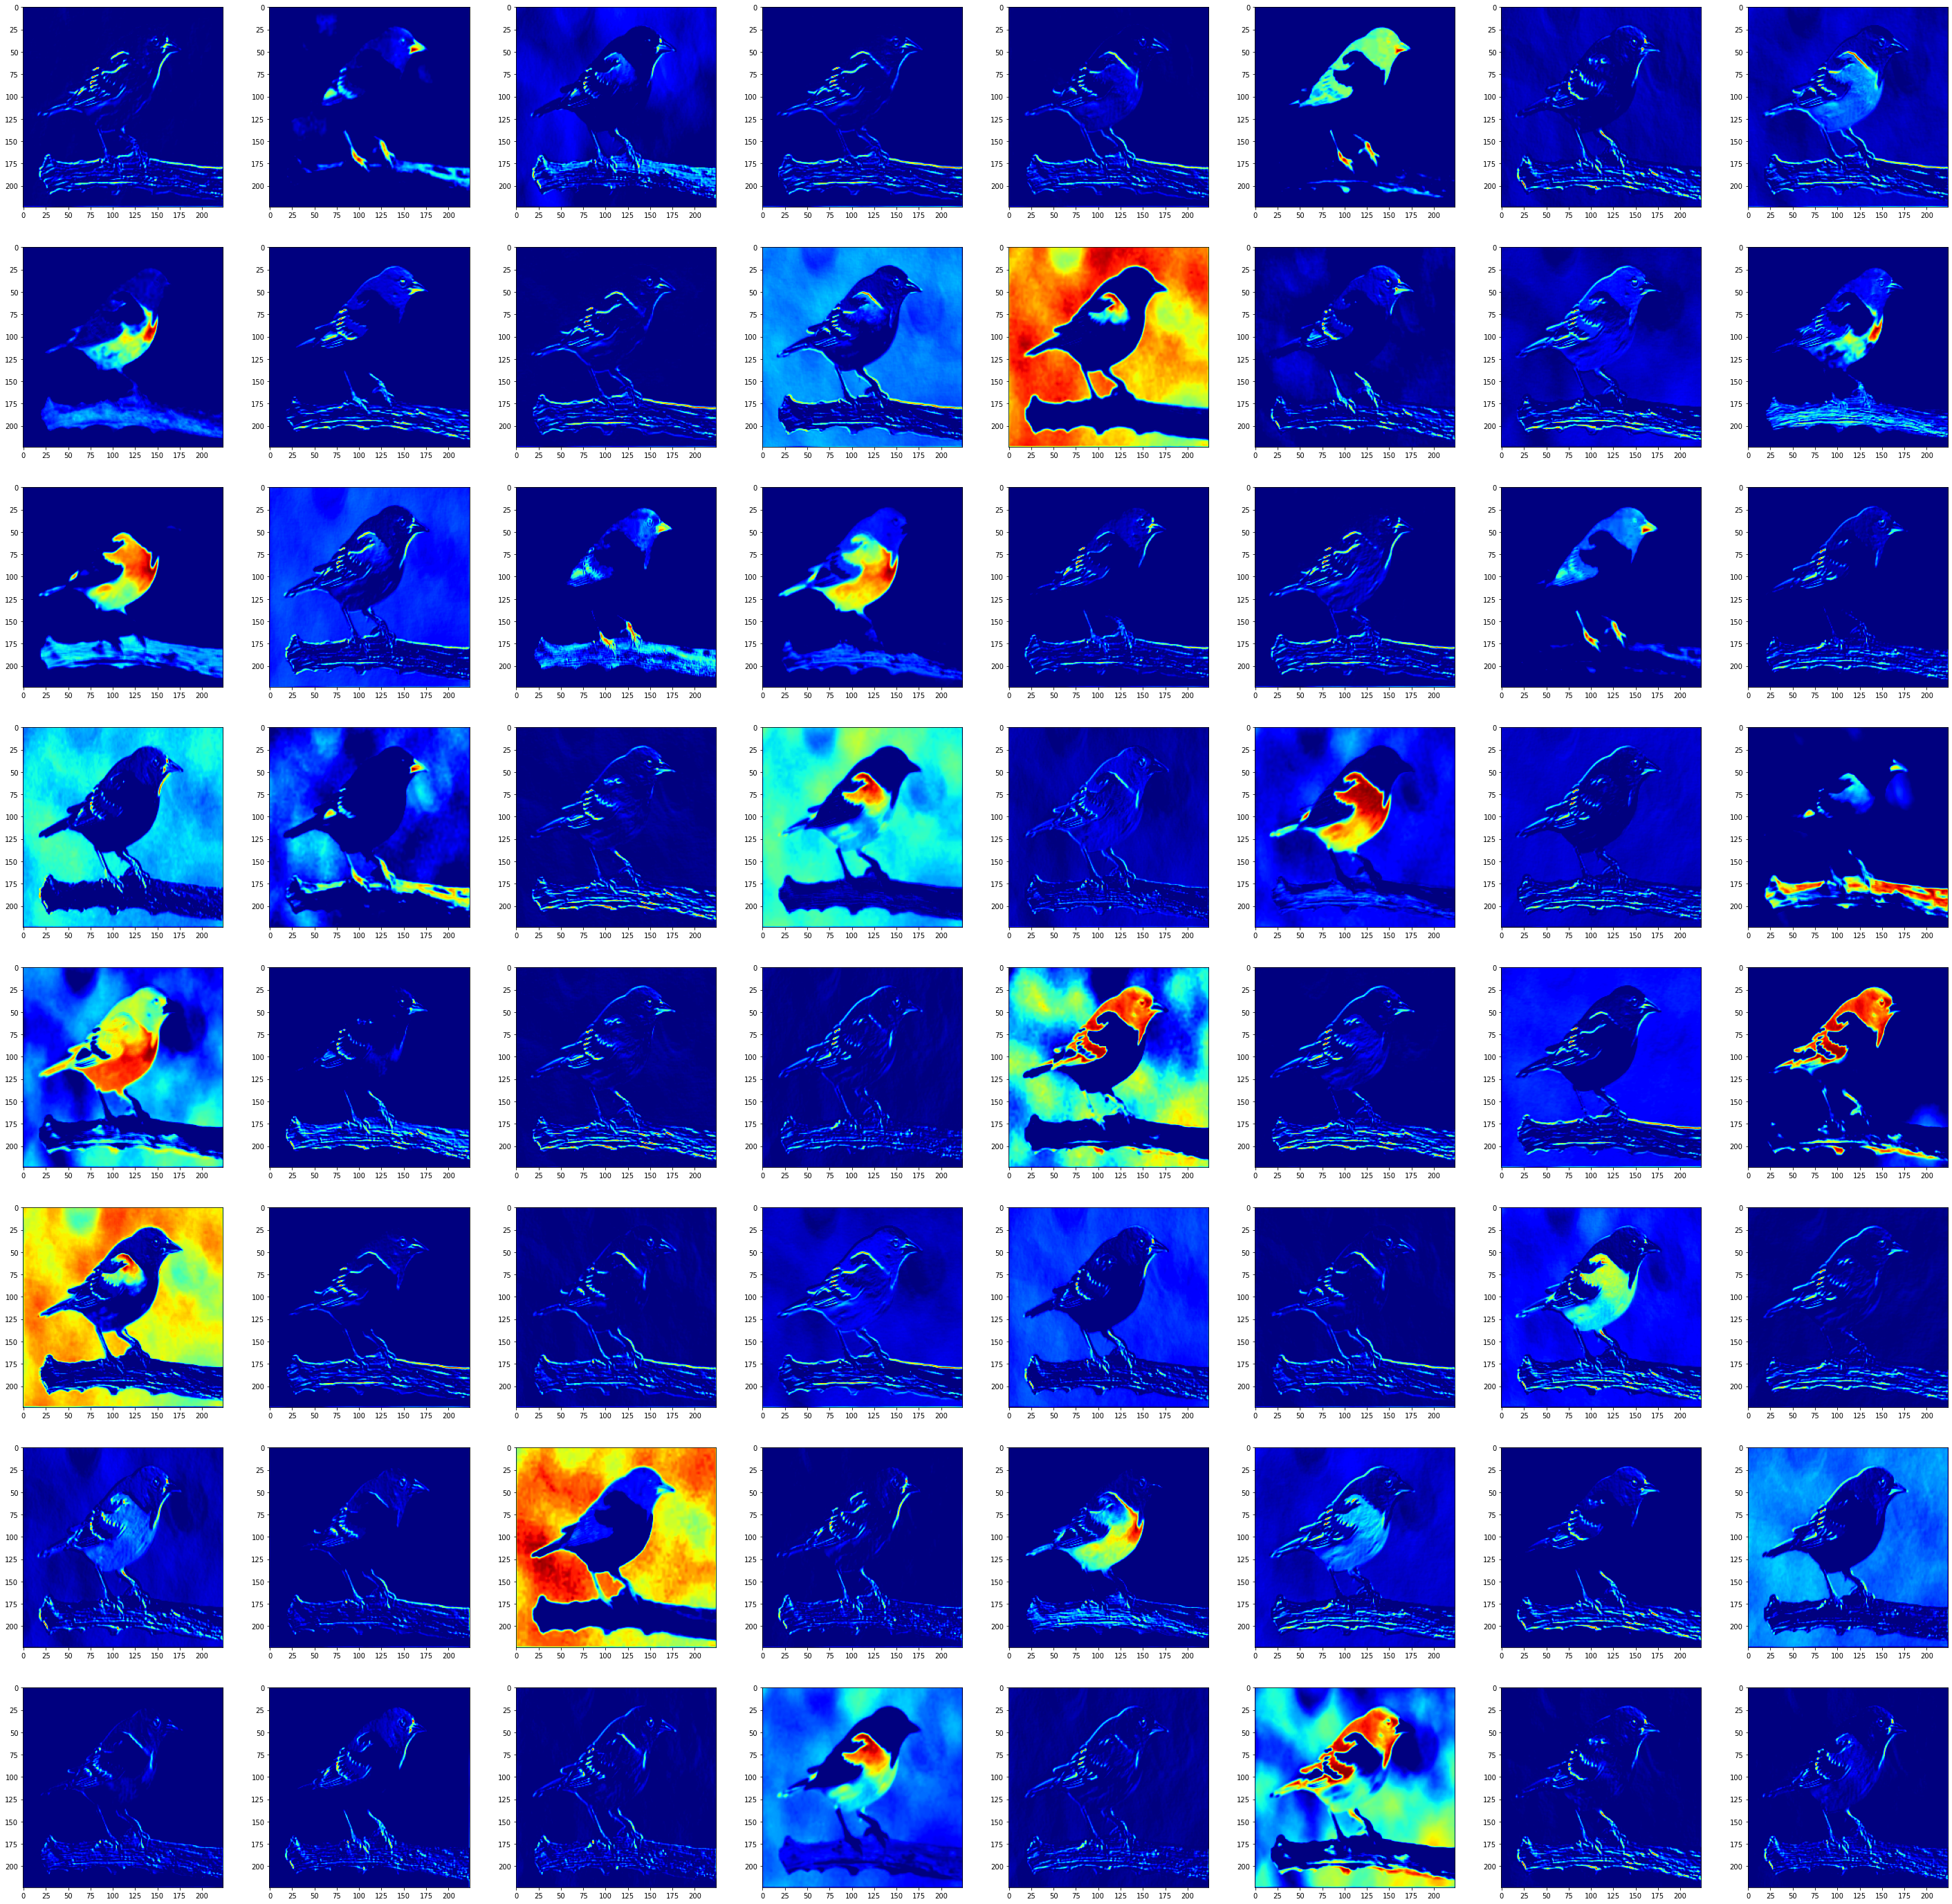

In [767]:
plt.figure(figsize=(50,50))
for i in range(0,64,1):
    # image convolution with kernel แยกแต่ละ color channel (ทํา ทุก color channel)
    for j in range(0,3,1):
        img_result[: , :, j] = signal.convolve2d( img_bgr[0][ : , : , j], kernels[: , : , j, i] , mode='same',boundary='fill', fillvalue=0)
    # Sum image convolutional results of B,G,R     
    Image_sum = img_result[ : , : , 0] + img_result[ : , : , 1] + img_result[ : , : , 2]
    # Activation Function
    for x in np.nditer(Image_sum, op_flags=['readwrite']):
        if x < 0:
            x[...] = 0
    # Display images of feature_maps
    ax = plt.subplot(square, square, i+1)
    plt.imshow(Image_sum,cmap = "jet")